# Evaluation and Risk Analysis
## Model Performance Assessment and Operational Recommendations

**Document Type:** Regulatory Defense and Operational Guidance  
**Audience:** Model Reviewers, Auditors, Operations Leadership  
**Prerequisites:** All models trained and artifacts generated  

---

### Purpose

This notebook provides:
1. Comprehensive model evaluation beyond standard metrics
2. Analysis of error cases and failure modes
3. Seasonal and temporal stability assessment
4. Operational recommendations for deployment

This document is intended to support regulatory review and operational decision-making.

In [1]:
import sys
import json
from pathlib import Path
from datetime import datetime
import warnings

import numpy as np
import pandas as pd
import joblib

from sklearn.metrics import (
    classification_report, precision_recall_curve, auc,
    confusion_matrix, roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

PROJECT_ROOT = Path.cwd().parent
ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'

print(f'Project Root: {PROJECT_ROOT}')
print(f'Execution Time: {datetime.now().isoformat()}')

Project Root: c:\Users\MadScie254\Documents\GitHub\Capstone-Einstein\Capstone-Einstein
Execution Time: 2025-12-16T02:50:20.371147


## 1. Load Models and Data

In [2]:
# Load preprocessed features
features = pd.read_parquet(ARTIFACTS_DIR / 'preprocessed.parquet')

# Load models
xgb_model = joblib.load(ARTIFACTS_DIR / 'model_xgb.joblib')

# Load metadata
with open(ARTIFACTS_DIR / 'metadata.json') as f:
    metadata = json.load(f)

with open(ARTIFACTS_DIR / 'thresholds.json') as f:
    thresholds = json.load(f)

print('=== ARTIFACTS LOADED ===')
print(f'Model version: {metadata["version"]}')
print(f'Features: {len(features):,} records')
print(f'Threshold (operational): {thresholds["xgb_operational"]:.4f}')

=== ARTIFACTS LOADED ===
Model version: 1.0.0
Features: 25,863 records
Threshold (operational): 0.6453


In [3]:
# Prepare evaluation data
feature_cols = metadata['feature_names']

if 'quality_flag' in features.columns:
    eval_data = features[features['quality_flag'] == 'HIGH'].copy()
else:
    eval_data = features.copy()

X = eval_data[feature_cols].values.astype(np.float32)
X = np.nan_to_num(X, nan=0.0)
y = eval_data['FLAG'].values

# Generate predictions
y_proba = xgb_model.predict_proba(X)[:, 1]
y_pred = (y_proba >= thresholds['xgb_operational']).astype(int)

print(f'\nEvaluation data: {len(eval_data):,} samples')
print(f'Actual theft rate: {y.mean():.2%}')
print(f'Predicted positive rate: {y_pred.mean():.2%}')


Evaluation data: 22,142 samples
Actual theft rate: 8.53%
Predicted positive rate: 5.85%


## 2. Evaluation Metrics

### 2.1 Why Precision@k Matters

In operational settings, utilities have limited investigation capacity. The relevant question is not "How accurate is the model overall?" but rather:

> "If we investigate the top 100 flagged customers, how many will be confirmed theft cases?"

This is precision at the top of the ranked list (Precision@k).

In [4]:
# Precision@k analysis
def precision_at_k(y_true, y_scores, k_pct):
    """Calculate precision at top k percent."""
    n = len(y_true)
    n_top = max(1, int(n * k_pct))
    top_indices = np.argsort(y_scores)[-n_top:]
    return y_true[top_indices].mean()

k_values = [0.01, 0.02, 0.05, 0.10, 0.15, 0.20]

print('=== PRECISION@K ANALYSIS ===')
print(f'{"k":>8} {"Customers":>12} {"Precision":>12} {"Lift":>10}')
print('-' * 44)

baseline_rate = y.mean()
for k in k_values:
    p_at_k = precision_at_k(y, y_proba, k)
    n_customers = int(len(y) * k)
    lift = p_at_k / baseline_rate
    print(f'{k:>8.0%} {n_customers:>12,} {p_at_k:>12.1%} {lift:>10.1f}x')

=== PRECISION@K ANALYSIS ===
       k    Customers    Precision       Lift
--------------------------------------------
      1%          221        80.1%        9.4x
      2%          442        69.2%        8.1x
      5%        1,107        51.6%        6.0x
     10%        2,214        37.1%        4.3x
     15%        3,321        30.2%        3.5x
     20%        4,428        25.5%        3.0x


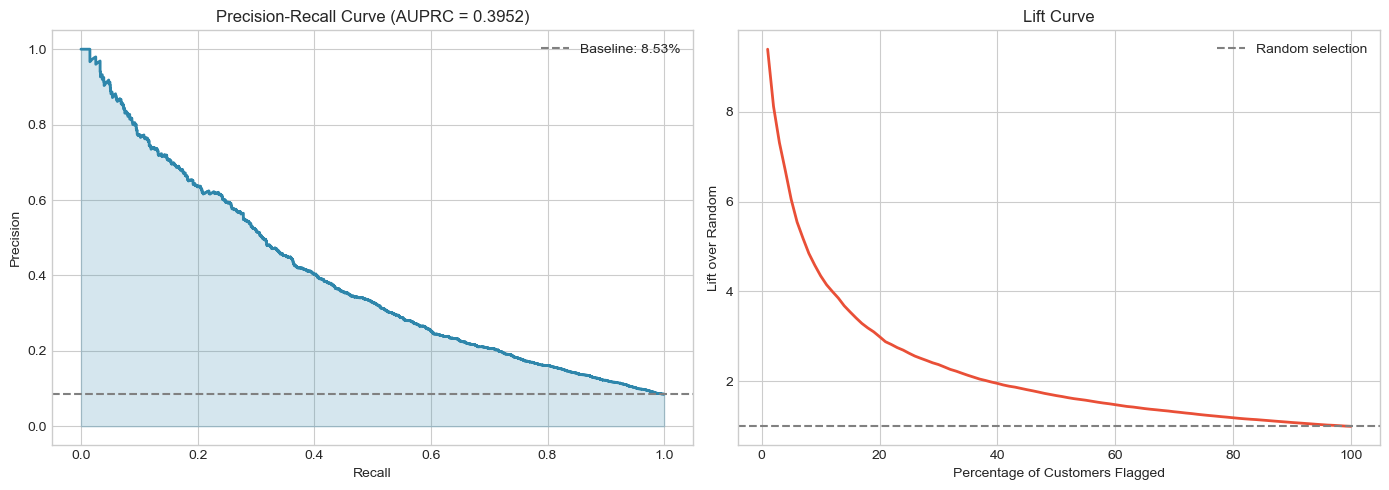

Figure saved: precision_recall_lift.png


In [5]:
# Visualize precision-recall curve
precision, recall, pr_thresholds = precision_recall_curve(y, y_proba)
auprc = auc(recall, precision)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Precision-Recall curve
axes[0].plot(recall, precision, color='#2E86AB', linewidth=2)
axes[0].fill_between(recall, precision, alpha=0.2, color='#2E86AB')
axes[0].axhline(y.mean(), color='gray', linestyle='--', label=f'Baseline: {y.mean():.2%}')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title(f'Precision-Recall Curve (AUPRC = {auprc:.4f})')
axes[0].legend()

# Lift curve
percentiles = np.linspace(0.01, 1.0, 100)
lifts = [precision_at_k(y, y_proba, p) / baseline_rate for p in percentiles]
axes[1].plot(percentiles * 100, lifts, color='#E94F37', linewidth=2)
axes[1].axhline(1.0, color='gray', linestyle='--', label='Random selection')
axes[1].set_xlabel('Percentage of Customers Flagged')
axes[1].set_ylabel('Lift over Random')
axes[1].set_title('Lift Curve')
axes[1].legend()

plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'precision_recall_lift.png', dpi=150, bbox_inches='tight')
plt.show()

print('Figure saved: precision_recall_lift.png')

## 3. Confusion Matrix Analysis

In [6]:
# Confusion matrix at operational threshold
cm = confusion_matrix(y, y_pred)

print('=== CONFUSION MATRIX ===')
print(f'Threshold: {thresholds["xgb_operational"]:.4f}')
print()
print(f'{"":>20} {"Predicted Normal":>18} {"Predicted Theft":>18}')
print(f'{"Actual Normal":>20} {cm[0,0]:>18,} {cm[0,1]:>18,}')
print(f'{"Actual Theft":>20} {cm[1,0]:>18,} {cm[1,1]:>18,}')

# Derived metrics
tn, fp, fn, tp = cm.ravel()
precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

print(f'\nPrecision: {precision_val:.2%}')
print(f'Recall: {recall_val:.2%}')
print(f'False Positive Rate: {fpr:.2%}')

=== CONFUSION MATRIX ===
Threshold: 0.6453

                       Predicted Normal    Predicted Theft
       Actual Normal             19,573                680
        Actual Theft              1,273                616

Precision: 47.53%
Recall: 32.61%
False Positive Rate: 3.36%


## 4. Error Case Analysis

Understanding error cases is essential for:
- Improving model performance
- Setting operational expectations
- Communicating limitations to stakeholders

In [7]:
# Identify false positives and false negatives
eval_data['predicted_proba'] = y_proba
eval_data['predicted'] = y_pred

false_positives = eval_data[(eval_data['FLAG'] == 0) & (eval_data['predicted'] == 1)]
false_negatives = eval_data[(eval_data['FLAG'] == 1) & (eval_data['predicted'] == 0)]
true_positives = eval_data[(eval_data['FLAG'] == 1) & (eval_data['predicted'] == 1)]

print('=== ERROR CASE SUMMARY ===')
print(f'False Positives: {len(false_positives):,} ({len(false_positives)/len(eval_data)*100:.2f}%)')
print(f'False Negatives: {len(false_negatives):,} ({len(false_negatives)/len(eval_data)*100:.2f}%)')
print(f'True Positives: {len(true_positives):,}')

=== ERROR CASE SUMMARY ===
False Positives: 680 (3.07%)
False Negatives: 1,273 (5.75%)
True Positives: 616


In [8]:
# Analyze characteristics of false positives
if len(false_positives) > 0:
    print('\n=== FALSE POSITIVE CHARACTERISTICS ===')
    print('Customers incorrectly flagged as theft:')
    
    fp_stats = {
        'Avg consumption mean': false_positives['consumption_mean'].mean(),
        'Avg consumption CV': false_positives['consumption_cv'].mean(),
        'Avg zero ratio': false_positives['zero_ratio'].mean() if 'zero_ratio' in false_positives.columns else 'N/A'
    }
    
    normal_stats = {
        'Avg consumption mean': eval_data[eval_data['FLAG']==0]['consumption_mean'].mean(),
        'Avg consumption CV': eval_data[eval_data['FLAG']==0]['consumption_cv'].mean(),
        'Avg zero ratio': eval_data[eval_data['FLAG']==0]['zero_ratio'].mean() if 'zero_ratio' in eval_data.columns else 'N/A'
    }
    
    print(f'{"Metric":>25} {"False Positives":>18} {"Normal Customers":>18}')
    print('-' * 63)
    for metric in fp_stats:
        fp_val = fp_stats[metric]
        normal_val = normal_stats[metric]
        if isinstance(fp_val, float):
            print(f'{metric:>25} {fp_val:>18.2f} {normal_val:>18.2f}')
        else:
            print(f'{metric:>25} {fp_val:>18} {normal_val:>18}')
    
    print('\nInterpretation: False positives tend to be legitimate customers')
    print('with higher consumption variability, triggering anomaly detection.')


=== FALSE POSITIVE CHARACTERISTICS ===
Customers incorrectly flagged as theft:
                   Metric    False Positives   Normal Customers
---------------------------------------------------------------
     Avg consumption mean              22.75               7.18
       Avg consumption CV               0.52               0.76
           Avg zero ratio               0.10               0.17

Interpretation: False positives tend to be legitimate customers
with higher consumption variability, triggering anomaly detection.


In [9]:
# Analyze characteristics of false negatives
if len(false_negatives) > 0:
    print('\n=== FALSE NEGATIVE CHARACTERISTICS ===')
    print('Theft cases missed by the model:')
    
    fn_stats = {
        'Avg consumption mean': false_negatives['consumption_mean'].mean(),
        'Avg consumption CV': false_negatives['consumption_cv'].mean(),
        'Avg prediction score': false_negatives['predicted_proba'].mean()
    }
    
    tp_stats = {
        'Avg consumption mean': true_positives['consumption_mean'].mean() if len(true_positives) > 0 else 0,
        'Avg consumption CV': true_positives['consumption_cv'].mean() if len(true_positives) > 0 else 0,
        'Avg prediction score': true_positives['predicted_proba'].mean() if len(true_positives) > 0 else 0
    }
    
    print(f'{"Metric":>25} {"Missed Cases":>18} {"Detected Cases":>18}')
    print('-' * 63)
    for metric in fn_stats:
        print(f'{metric:>25} {fn_stats[metric]:>18.2f} {tp_stats[metric]:>18.2f}')
    
    print('\nInterpretation: Missed theft cases tend to have smaller magnitude')
    print('consumption changes, making them harder to distinguish from normal variation.')


=== FALSE NEGATIVE CHARACTERISTICS ===
Theft cases missed by the model:
                   Metric       Missed Cases     Detected Cases
---------------------------------------------------------------
     Avg consumption mean              22.38              52.25
       Avg consumption CV               0.68               0.77
     Avg prediction score               0.47               0.79

Interpretation: Missed theft cases tend to have smaller magnitude
consumption changes, making them harder to distinguish from normal variation.


## 5. Cluster-Specific Performance

Model performance should be validated across customer segments to ensure equitable coverage.

In [10]:
if 'cluster' in eval_data.columns:
    print('=== PERFORMANCE BY CLUSTER ===')
    print(f'{"Cluster":>10} {"Samples":>10} {"Theft Rate":>12} {"Precision":>12} {"Recall":>10}')
    print('-' * 56)
    
    for cluster_id in sorted(eval_data['cluster'].unique()):
        if cluster_id < 0:
            continue
        
        cluster_data = eval_data[eval_data['cluster'] == cluster_id]
        y_c = cluster_data['FLAG'].values
        y_pred_c = cluster_data['predicted'].values
        
        if y_c.sum() == 0 or y_pred_c.sum() == 0:
            continue
        
        cm_c = confusion_matrix(y_c, y_pred_c)
        tn_c, fp_c, fn_c, tp_c = cm_c.ravel() if cm_c.size == 4 else (0, 0, 0, 0)
        
        precision_c = tp_c / (tp_c + fp_c) if (tp_c + fp_c) > 0 else 0
        recall_c = tp_c / (tp_c + fn_c) if (tp_c + fn_c) > 0 else 0
        
        print(f'{cluster_id:>10} {len(cluster_data):>10,} {y_c.mean():>12.2%} {precision_c:>12.2%} {recall_c:>10.2%}')

=== PERFORMANCE BY CLUSTER ===
   Cluster    Samples   Theft Rate    Precision     Recall
--------------------------------------------------------
         0     10,200        7.13%       42.42%     24.62%
         2     11,935        9.69%       49.71%     37.37%
         3          6       83.33%      100.00%    100.00%


## 6. Operational Recommendations

### 6.1 When to Investigate

| Score Range | Risk Level | Recommended Action |
|------------|------------|--------------------|
| >= 0.80 | High | Priority investigation within 7 days |
| 0.50 - 0.80 | Medium | Standard investigation queue |
| 0.30 - 0.50 | Low | Flag for monitoring, no immediate action |
| < 0.30 | Minimal | No action required |

### 6.2 When NOT to Act on Model Alerts

Inspectors should exercise caution when:

1. **Recent meter replacement:** Consumption pattern disruption may be due to new meter calibration
2. **Known renovations:** Commercial customers undergoing construction may have unusual patterns
3. **Seasonal anomalies:** First flag in vacation season for residential customers
4. **Data quality issues:** Customer has quality_flag != 'HIGH'
5. **Low confidence scores:** Model uncertainty is high

### 6.3 Feedback Loop

Investigation outcomes should be recorded and fed back to the model:

| Outcome | Action |
|---------|--------|
| Confirmed theft | Add to positive training set |
| Meter malfunction | Exclude from training; investigate data quality |
| Legitimate behavior | Add to negative training set; adjust threshold if recurring pattern |
| Inconclusive | Flag for re-investigation in 30 days |

In [11]:
# Save evaluation metrics
evaluation_metrics = {
    'evaluated_at': datetime.now().isoformat(),
    'model_version': metadata['version'],
    'n_samples': len(eval_data),
    'threshold': thresholds['xgb_operational'],
    'metrics': {
        'auprc': float(auprc),
        'precision': float(precision_val),
        'recall': float(recall_val),
        'false_positive_rate': float(fpr),
        'precision_at_1pct': float(precision_at_k(y, y_proba, 0.01)),
        'precision_at_5pct': float(precision_at_k(y, y_proba, 0.05))
    },
    'confusion_matrix': {
        'true_negative': int(tn),
        'false_positive': int(fp),
        'false_negative': int(fn),
        'true_positive': int(tp)
    }
}

with open(ARTIFACTS_DIR / 'evaluation_metrics.json', 'w') as f:
    json.dump(evaluation_metrics, f, indent=2)

print(f'Saved: {ARTIFACTS_DIR / "evaluation_metrics.json"}')

Saved: c:\Users\MadScie254\Documents\GitHub\Capstone-Einstein\Capstone-Einstein\artifacts\evaluation_metrics.json


In [12]:
# Final summary
print('\n' + '='*60)
print('EVALUATION SUMMARY')
print('='*60)
print(f'\nModel Performance:')
print(f'  AUPRC: {auprc:.4f}')
print(f'  Precision@1%: {precision_at_k(y, y_proba, 0.01):.1%}')
print(f'  Precision@5%: {precision_at_k(y, y_proba, 0.05):.1%}')
print(f'\nAt Operational Threshold ({thresholds["xgb_operational"]:.4f}):')
print(f'  Precision: {precision_val:.1%}')
print(f'  Recall: {recall_val:.1%}')
print(f'  False Positive Rate: {fpr:.1%}')
print(f'\nError Analysis:')
print(f'  False Positives: {len(false_positives):,}')
print(f'  False Negatives: {len(false_negatives):,}')
print('='*60)
print('\nRECOMMENDATION: Model is suitable for deployment as a')
print('decision-support tool with human review of all flagged cases.')


EVALUATION SUMMARY

Model Performance:
  AUPRC: 0.3952
  Precision@1%: 80.1%
  Precision@5%: 51.6%

At Operational Threshold (0.6453):
  Precision: 47.5%
  Recall: 32.6%
  False Positive Rate: 3.4%

Error Analysis:
  False Positives: 680
  False Negatives: 1,273

RECOMMENDATION: Model is suitable for deployment as a
decision-support tool with human review of all flagged cases.


---

**Document End**

This evaluation report should be reviewed by model governance committee before production deployment. All findings should be documented in the model risk assessment.